In [18]:
json_folders = {
    "alpha": ["/home/tjw/Documents/gopro/alpha_json"],
    "beta": ["/home/tjw/Documents/gopro/beta_json"],
    "gamma": ["/home/tjw/Documents/gopro/gamma_json"],
    "delta": ["/home/tjw/Documents/gopro/delta_json"],
    "epsilon": ["/home/tjw/Documents/gopro/epsilon_json"],
    "zeta": ["/home/tjw/Documents/gopro/zeta_json"],
    "eta": ["/home/tjw/Documents/gopro/eta_json"]
}


In [19]:
import json, os

data = {}
for greek in json_folders:
    data[greek] = []
    for file in os.listdir(json_folders[greek][0]):
        with open(os.path.join(json_folders[greek][0], file)) as file:
            data[greek].append(json.load(file))

data


{'alpha': [[{'frame': 0,
    'cam_gps': {'lat': '40.4937808', 'lon': '-85.6715021'},
    'gps_time': '2023-05-30T19:12:47.055000Z'},
   {'frame': 1,
    'cam_gps': {'lat': '40.4937808', 'lon': '-85.6715021'},
    'gps_time': '2023-05-30T19:12:49.310000Z'},
   {'frame': 2,
    'cam_gps': {'lat': '40.4937808', 'lon': '-85.6715021'},
    'gps_time': '2023-05-30T19:12:50.355000Z'},
   {'frame': 3,
    'cam_gps': {'lat': '40.4937808', 'lon': '-85.6715021'},
    'gps_time': '2023-05-30T19:12:51.345000Z'},
   {'frame': 4,
    'cam_gps': {'lat': '40.4937808', 'lon': '-85.6715021'},
    'gps_time': '2023-05-30T19:12:52.335000Z'},
   {'frame': 5,
    'cam_gps': {'lat': '40.4937808', 'lon': '-85.6715021'},
    'gps_time': '2023-05-30T19:12:53.325000Z'},
   {'frame': 6,
    'cam_gps': {'lat': '40.4937808', 'lon': '-85.6715021'},
    'gps_time': '2023-05-30T19:12:54.370000Z'},
   {'frame': 7,
    'cam_gps': {'lat': '40.4937808', 'lon': '-85.6715021'},
    'gps_time': '2023-05-30T19:12:55.305000Z'},

In [29]:
data["alpha"][5][0] # example of old-style cam data

{'frame': 0,
 'file': 'alpha/20230508_081700.JPG',
 'cam_timestamp': {'date': ['2023', '05', '08'],
  'time': ['08', '17', '00'],
  'ms': 191}}

In [30]:
data["alpha"][0][0] # example of new-style cam data

{'frame': 0,
 'cam_gps': {'lat': '40.4937808', 'lon': '-85.6715021'},
 'gps_time': '2023-05-30T19:12:47.055000Z'}

In [22]:
def newCoords(jsondata): # returns list of (lon,lat) tuples
    output = []
    for frame in jsondata:
        lon = frame["cam_gps"]["lon"]
        lat = frame["cam_gps"]["lat"]
        output.append((lon,lat))
    return output


In [23]:
gps = {}
for tractor in data:
    gps[tractor] = []
    for file in data[tractor]:
        if "cam_gps" in file[0].keys():
            gps[tractor] += newCoords(file)

In [24]:
import geojson
from shapely.geometry import Polygon

with open("County_Boundaries_of_Indiana_2023.geojson") as file:
    IN_COUNTIES = geojson.load(file)

counties = {}
for i in range(len(IN_COUNTIES["features"])):
    name = IN_COUNTIES["features"][i]["properties"]["name"]
    name = name.split(" County")[0]
    counties[name] = Polygon(IN_COUNTIES["features"][i]["geometry"]["coordinates"][0][0])


In [25]:
# Copied from https://stackoverflow.com/a/70533052
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def plot_polygon(ax, poly, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection

In [26]:
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Greedy (but still slow) County Checker
def check_county(coords, county):
    for point in coords:
        if county.contains(Point(point)):
            return True
    return False

# Get list of counties for each tractor
data_counties = {}
for tractor in gps:
    data_counties[tractor] = []
    for county in counties:
        if check_county(gps[tractor], counties[county]):
            data_counties[tractor].append(county)
    print(f"{tractor}: {data_counties[tractor]}")


alpha: ['Adams', 'Allen', 'Blackford', 'Dekalb', 'Elkhart', 'Fulton', 'Jasper', 'Kosciusko', 'Laporte', 'Madison', 'Marion', 'Newton', 'Noble', 'Porter', 'Rush', 'Starke', 'Tipton', 'Warren', 'Benton', 'Grant', 'Howard', 'Huntington', 'Lagrange', 'Miami', 'Marshall', 'Steuben', 'Wabash', 'White', 'Whitley', 'Wells']
beta: ['Adams', 'Allen', 'Blackford', 'Brown', 'Dekalb', 'Delaware', 'Elkhart', 'Fulton', 'Hamilton', 'Jasper', 'Kosciusko', 'Laporte', 'Madison', 'Noble', 'Pulaski', 'Randolph', 'Grant', 'Huntington', 'Jay', 'Lagrange', 'Steuben', 'Wabash', 'White', 'Whitley', 'Wells']
gamma: []
delta: ['Brown', 'Delaware', 'Madison', 'Randolph', 'Tipton', 'Cass', 'Grant', 'Howard', 'Miami', 'Orange']
epsilon: ['St Joseph', 'Grant', 'Marshall']
zeta: ['Adams', 'Allen', 'Clark', 'Fulton', 'Jasper', 'Jefferson', 'Lake', 'Newton', 'Noble', 'Porter', 'Scott', 'Starke', 'Jay', 'Lawrence', 'Monroe', 'Marshall', 'Wells']
eta: ['Allen', 'Blackford', 'Delaware', 'Fayette', 'Franklin', 'Henry', 'Jac

In [27]:
countylist = []
for tractor in data_counties:
    for county in data_counties[tractor]:
        if county not in countylist:
            countylist.append(county)

countylist.sort()
print(countylist)


['Adams', 'Allen', 'Benton', 'Blackford', 'Brown', 'Cass', 'Clark', 'Decatur', 'Dekalb', 'Delaware', 'Elkhart', 'Fayette', 'Franklin', 'Fulton', 'Grant', 'Hamilton', 'Henry', 'Howard', 'Huntington', 'Jackson', 'Jasper', 'Jay', 'Jefferson', 'Jennings', 'Johnson', 'Kosciusko', 'Lagrange', 'Lake', 'Laporte', 'Lawrence', 'Madison', 'Marion', 'Marshall', 'Martin', 'Miami', 'Monroe', 'Newton', 'Noble', 'Orange', 'Porter', 'Pulaski', 'Randolph', 'Rush', 'Scott', 'St Joseph', 'Starke', 'Steuben', 'Tipton', 'Wabash', 'Warren', 'Warrick', 'Wells', 'White', 'Whitley']


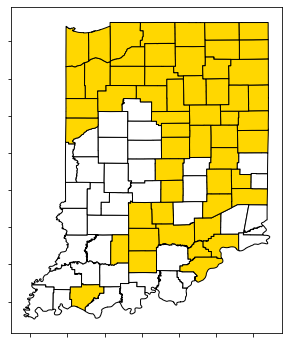

In [28]:
fig, ax = plt.subplots()
for county in counties:
    if county in countylist:
        plot_polygon(ax, counties[county], facecolor="gold", edgecolor="black")
    else:
        plot_polygon(ax, counties[county], facecolor="white", edgecolor="black")

ax.set_xticklabels("")
ax.set_yticklabels("")
fig.set_size_inches(6,6)
ax.set_aspect(1.0)
